In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random as rng

In [2]:
# Here we'll try find the bounding boxes for the cells (and the impurities) using OpenCV.
# It'll be a lot easier to train the actual ML model if we can easily generate the bounding boxes.
# We'll follow https://docs.opencv.org/4.x/da/d0c/tutorial_bounding_rects_circles.html.

path = 'data/processed_split/0001.png'
src_gray = cv.imread(path, cv.IMREAD_GRAYSCALE)

if src_gray is None:
    print('Could not open or find the image:', path)

# Let's scale the image down a bit
src_gray = cv.resize(src_gray,(720,480))

# We'll forgo further blurring of the image for now...
#src_gray = cv.blur(src_gray, (3,3))

In [3]:
# We'll take the callback function from the tutorial

def thresh_callback(val):
    threshold = val
    
    canny_output = cv.Canny(src_gray, threshold, threshold * 2)
    
    
    contours, _ = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    #centers = [None]*len(contours)
    #radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])
        #centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])
    
    
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    
    
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours_poly, i, color)
        cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        #cv.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
    
    
    return drawing

In [4]:
# Drawing from the threshold callback has a black background, we'll want to make that transparent.
# Adapted from https://stackoverflow.com/questions/40527769/removing-black-background-and-make-transparent-from-grabcut-output-in-python-ope
def make_transparent(src):
    tmp = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    _,alpha = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
    b, g, r = cv.split(src)
    rgba = [b,g,r, alpha]
    dst = cv.merge(rgba,4)
    return dst

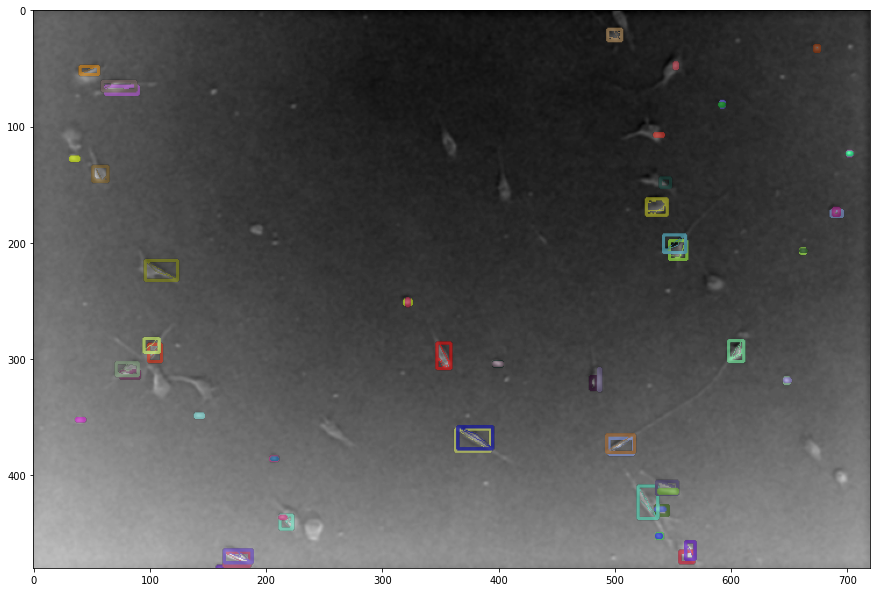

In [5]:
max_thresh = 255
thresh = 80 # initial threshold
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(src_gray, cmap='gray')
bboxes = make_transparent(thresh_callback(thresh))
ax.imshow(bboxes, alpha=0.6)

In [6]:
# It kind of works. Let's introduce more blur and see if that makes a difference.
# But first, add a helper function.

def plot_bboxes(image, threshold):
    
    canny_output = cv.Canny(image, threshold, threshold * 2)
    
    
    contours, _ = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])
    
    
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    
    
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours_poly, i, color)
        cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        
    # Plot as before
    max_thresh = 255
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(image, cmap='gray')
    bboxes = make_transparent(drawing)
    ax.imshow(bboxes, alpha=0.6)

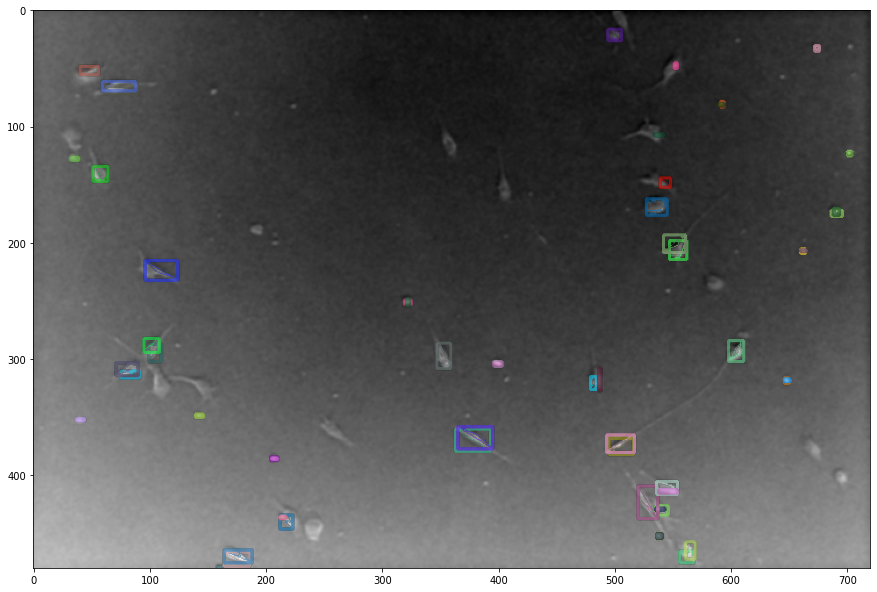

In [7]:
plot_bboxes(src_gray,80)

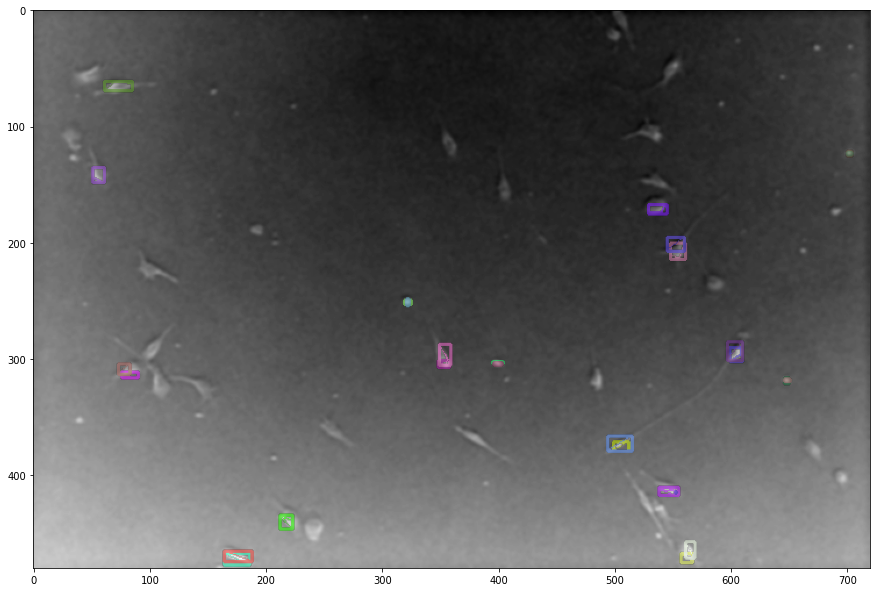

In [8]:
# Alright, now let try blurring some more.
src_gray = cv.blur(src_gray, (3,3))
plot_bboxes(src_gray,80)

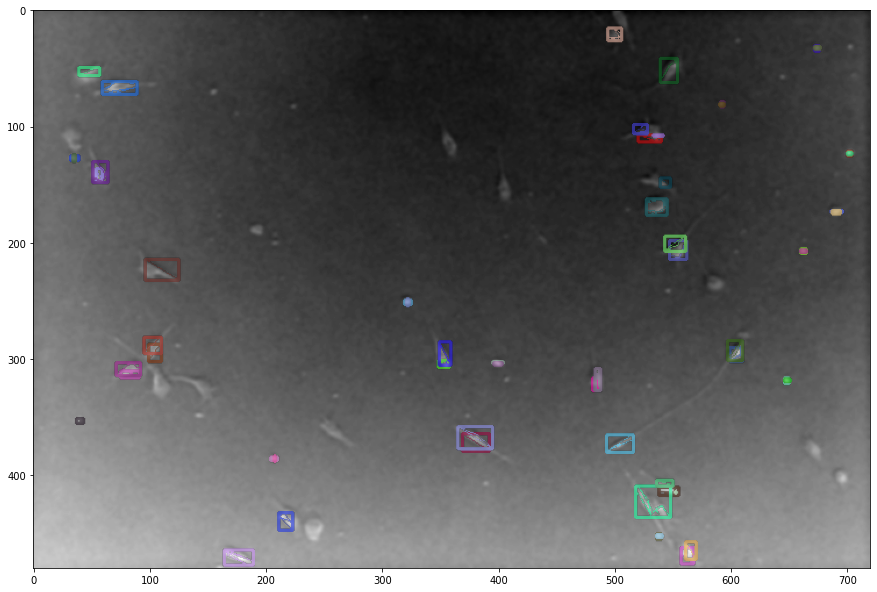

In [9]:
# That removed a lot of false positives, but it also removed some cells as well.
# Lower the threshold?
plot_bboxes(src_gray, 60)

In [10]:
# Better, but cells are being left out, and it's gaining false positives.
# Let's add even more blur.
blur_iterations = 5
for _ in range(blur_iterations):
    src_gray = cv.blur(src_gray, (3,3))

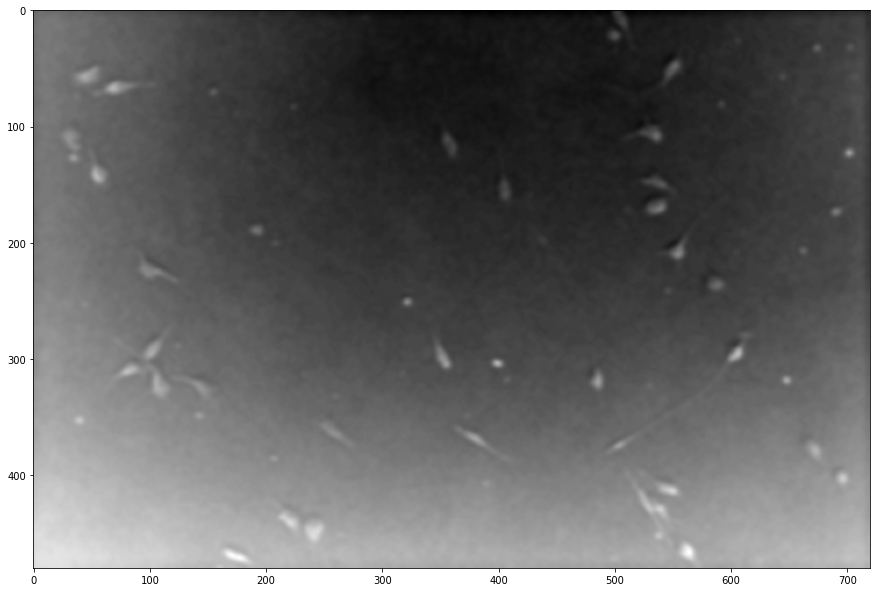

In [11]:
# Now this threshold returns nothing
plot_bboxes(src_gray, 80)

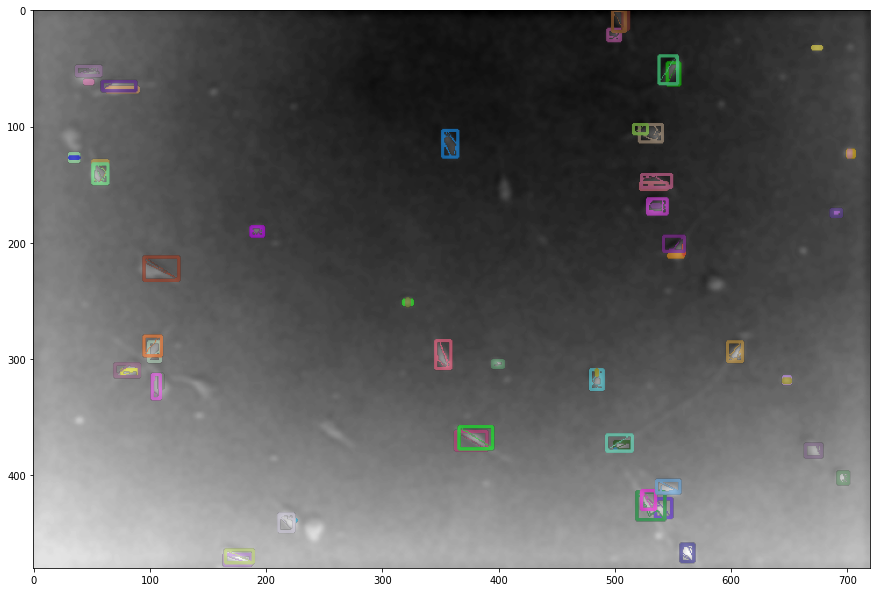

In [12]:
# Adjusting...
plot_bboxes(src_gray, 25)

In [13]:
# Alas, there just doesn't seem to be a good balance between the false-positives and finding all the cells.